In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shutil

In [2]:
img_height = 432
img_width = 288
train_directory = './data_eval/img_data/dustan/mel_spectrogram/allclass/'


In [3]:
def dummy(data,numarr):
    new_data =[]
    for i in data:
        lab_data = []
        for j in range(0,numarr):
            lab_data.append(0)
        #lab_data =[0,0]
        lab_data[i] = 1
        new_data.append(lab_data)
    return new_data

In [4]:
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight 

In [5]:

def createdict(num):
    lab_data = []
    for i in range(0,num):
        lab_data.append(i)
    dic = dict.fromkeys(lab_data, 0)
    return dic

In [6]:
def createWeight(class_count,num_classes):
    class_weights = createdict(num_classes)
    for i in range(num_classes):
        class_weights[i]=create_weight(np.sum(class_count),num_classes,class_count[i])
    return class_weights

In [7]:
def preprocess(data_dir,numclass):
    data_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, labels='inferred', label_mode='int', image_size=(432, 288), seed=321,
    validation_split=None, subset=None)
    class_names = data_ds.class_names
    
    feature=[]
    label=[]
    for images, labels in data_ds.unbatch().take(-1):
        feature.append(images.numpy())
        label.append(labels.numpy())
        
    feature = np.array(feature)
    label = np.array(label)      
    
    
    class_count=[]
    for i in range(0,numclass):
        class_count.append(np.count_nonzero(label == i))
    class_count = np.array(class_count)
    label = dummy(label,numclass)
    class_weights = createWeight(class_count,numclass)
   
    
    label = np.array(label)
    return feature,label,class_weights,class_names
    

In [8]:
feature,label,class_weights,class_names = preprocess(train_directory,5)

Found 180 files belonging to 5 classes.


In [9]:
class_names

['burping', 'discomfort', 'hungry', 'poop', 'tired']

In [10]:
def categories2binary(categories):
    binarydata = []
    for item in categories:
        binarydata.append(item[0])
    binarydata=np.array(binarydata)
    return(binarydata)

In [11]:
def binary2categories(binary):
    new_data = []
    for i in binary:
        lab_data = []
        for j in range(0,2):
            lab_data.append(0)
        if(i>=0.5):
            lab_data[1]=1;
        elif(i<0.5):
            lab_data[0]=1;
        new_data.append(lab_data)
    new_data = np.array(new_data)
    return(new_data)

In [13]:
# split_class_base_model = tf.keras.applications.ResNet50(
#     weights="imagenet",  # Load weights pre-trained on ImageNet.
#     input_shape=(img_height, img_width, 3),
#     include_top=False,
# ) 

# Freeze the base_model
# split_class_base_model.trainable = False

# Create new model on top
    
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = inputs

# x = split_class_base_model(x, training=False)
x = tf.keras.layers.Conv2D(80, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
            
# x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(5,activation='softmax')(x)
split_class_model = tf.keras.Model(inputs, outputs)

split_class_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 432, 288, 80)      2240      
                                                                 
 conv2d_2 (Conv2D)           (None, 432, 288, 128)     92288     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 216, 144, 128)    0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3981312)           0         
                                                                 
 dense_2 (Dense)             (None, 128)               509608064 
                                                           

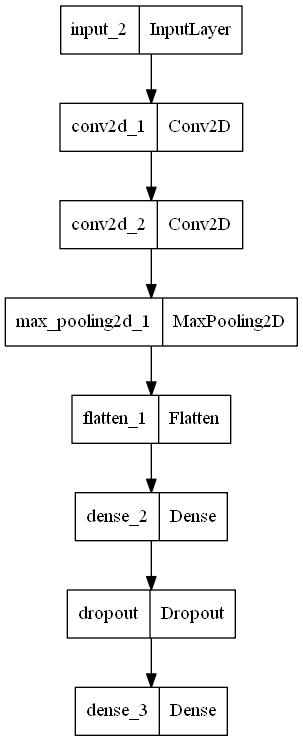

In [14]:

tf.keras.utils.plot_model(split_class_model,to_file="model_summary.png")

In [15]:

loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
split_class_model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = split_class_model.fit(feature, label, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()



Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\Users\acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-ede032ab456a>", line 7, in <module>
    history = split_class_model.fit(feature, label, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)
  File "c:\Users\acer\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\acer\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
    tmp_logs = self.train_function(iterator)
  File "c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "c:\Users\ace

KeyboardInterrupt: 

In [ ]:
import shutil
from pydub import AudioSegment
import time

c:\Users\acer\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [ ]:
def load_audio(file_path):
    waveform, sample_rate = librosa.load(file_path)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        # Load audio
        waveform, sample_rate = load_audio(file_path)
        audio_segment = AudioSegment.from_file(file_path)
        dataset.append([waveform, sample_rate,audio_segment])

    return dataset


In [17]:
def mel_spectrogram(waveform,sample,n_fft=2560,hop_length=32):
    #fast_fourier_transf = np.fft.fft(waveform)
   
    audio_stft = librosa.feature.melspectrogram(y=waveform,n_fft=n_fft,hop_length=hop_length,fmin = 20,fmax = sample//2)
    log_spectro = librosa.power_to_db(audio_stft)
    librosa.display.specshow(log_spectro, sr=sample, x_axis='time', y_axis='mel',cmap = 'magma')
    
    
    return log_spectro

In [18]:
def mel_freq(waveform,sample):
    mfccs = librosa.feature.mfcc(waveform, sr=sample,dct_type = 2,n_mfcc=100)
    # data = librosa.power_to_db(mfccs)
    # Displaying  the MFCCs:
    librosa.display.specshow(mfccs, sr=sample, x_axis='mel',cmap = 'magma')
    return mfccs

In [19]:
def create_images(data,typeimg):
    # make directory

    test_directory = f'./testImgArea/y_label/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    sample_rate = data[1]
    waveform = data[0]
    if typeimg == 'mel_spectrogram':
        spectrogram = mel_spectrogram(waveform,sample_rate)
    elif typeimg == 'mel_freq':
        spectrogram = mel_freq(waveform,sample_rate)
    librosa.display.specshow(spectrogram,sr=sample_rate, x_axis='time')
    plt.axis('off')
    plt.savefig(f'./testImgArea/y_label/test_{typeimg}.jpg', bbox_inches="tight", pad_inches = 0)
    plt.clf()

In [20]:
def getTestData():
    
    data_ds = tf.keras.preprocessing.image_dataset_from_directory('./testImgArea/', labels='inferred', label_mode='int', image_size=(432, 288), seed=321,validation_split=None, subset=None)
    fe=[]
    lab=[]
    for images, labels in data_ds.unbatch().take(-1):
        fe.append(images.numpy())
        lab.append(labels.numpy())

    return np.array(fe),np.array(lab)

In [ ]:
predictset= []
labelset = []

In [34]:
def predict_infant(class_test_data,y_label):
    for testobj in class_test_data:
        create_images(testobj,typeimg ='mel_spectrogram')
        x,y = getTestData()
        os.remove('./testImgArea/y_label/test_mel_spectrogram.jpg')
        pred = split_class_model.predict(x)
        y_pred_class = np.argmax(pred, axis=1)
        predictset.append(y_pred_class)
        labelset.append(y_label)
        plt.clf()
    

In [35]:
burping_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/burpme/', 'burpme')
tired_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/tired_owh/', 'tired')
hungry_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/hungry_Nah/', 'hungry')
poop_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/poop_eairh/', 'poop')
discomfort_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/uncomfortable_heh/', 'discomfort')

In [36]:
class_names

['burping', 'discomfort', 'hungry', 'poop', 'tired']

In [37]:
predict_infant(discomfort_test_data,1)
predict_infant(hungry_test_data,2)
predict_infant(tired_test_data,4)
predict_infant(burping_test_data,0)
predict_infant(poop_test_data,3)

Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 file

<Figure size 432x288 with 0 Axes>

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       0.83      0.71      0.77         7
           2       0.54      0.88      0.67         8
           3       0.88      0.70      0.78        10
           4       0.83      0.45      0.59        11

    accuracy                           0.75        48
   macro avg       0.78      0.75      0.74        48
weighted avg       0.78      0.75      0.74        48



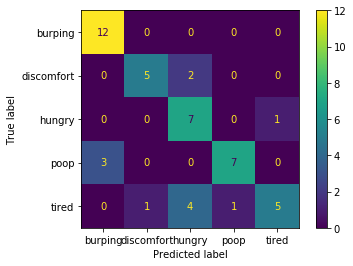

In [38]:

cm = confusion_matrix(labelset, predictset)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(labelset, predictset))